In [1]:
import os
import pandas as pd
import datetime
from datetime import date
import time
import numpy as np

## Download [this query on Quarry](https://quarry.wmcloud.org/query/59058) of 50k random users (with userpages who registered before 2020-10)

In [2]:
!wget https://quarry.wmcloud.org/run/585296/output/0/tsv -O user_reg_with_userpages.tsv

--2021-10-06 22:14:02--  https://quarry.wmcloud.org/run/585296/output/0/tsv
Resolving quarry.wmcloud.org (quarry.wmcloud.org)... 172.16.0.164
Connecting to quarry.wmcloud.org (quarry.wmcloud.org)|172.16.0.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tab-separated-values]
Saving to: ‘user_reg_with_userpages.tsv’

user_reg_with_userp     [  <=>               ]   1.71M  4.42MB/s    in 0.4s    

2021-10-06 22:14:03 (4.42 MB/s) - ‘user_reg_with_userpages.tsv’ saved [1795476]



In [3]:
!wc -l user_reg_with_userpages.tsv

50001 user_reg_with_userpages.tsv


In [4]:
!head user_reg_with_userpages.tsv

In [5]:
editors_df = pd.read_csv('user_reg_with_userpages.tsv', delimiter='\t', infer_datetime_format=True)
editors_df

,user_name,user_id,user_registration
0,KingRiach,27773404,20160307220704
1,Ctambo,6492102,20080221002533
2,Awisely,13820329,20110118230413
3,Shankhamita,16009368,20120101171414
4,Abhinayaprithivi,28005397,20160404204752
...,...,...,...
49995,Bandgeek1732,16336675,20120221035543
49996,Werqty12376,18321203,20130125002347
49997,Chrisboote,482416,20051007102059
49998,Mariibog,24622706,20150402172429


### Function for calculating future dates

In [6]:
def add_days(d, days):

    return d + datetime.timedelta(days=days)


In [7]:
add_days(datetime.datetime(2010,1,1),365)

datetime.datetime(2011, 1, 1, 0, 0)

In [8]:
add_days(datetime.datetime(2010,1,1),364)

datetime.datetime(2010, 12, 31, 0, 0)

## Building one SQL query for each user's edits

In [9]:
query_list = []
reg_year_mo_list = []
for index, row in editors_df.iterrows():
    user_registration = row['user_registration']
    reg_dt = datetime.datetime.strptime(str(user_registration), "%Y%m%d%H%M%S")

    start_date = add_days(reg_dt, 182)
    end_date = add_days(reg_dt, 365)
    reg_year_mo = reg_dt.strftime("%Y-%m")
    
    reg_year_mo_list.append(reg_year_mo)
    

#    query = "select " + str(row['user_id']) + " as user_id, " + str(row['user_registration']) + " as user_registration,"
#    query += "'" + str(reg_year_mo) + "' as year_mo, "
#    query += """s.* from ( select rev_id from revision_userindex where rev_actor = """ + str(row['user_id'])
#    query += " and rev_timestamp > " + start_date.strftime("%Y%m%d%H%M%S") 
#    query += " and rev_timestamp < " + end_date.strftime("%Y%m%d%H%M%S") + ") as s"

    query = "select * from revision_userindex where rev_actor = " + str(row['user_id'])
    query += " and rev_timestamp > " + start_date.strftime("%Y%m%d%H%M%S") 
    query += " and rev_timestamp < " + end_date.strftime("%Y%m%d%H%M%S") + ";"

    query_list.append(query)

In [10]:
editors_df = pd.concat([editors_df,pd.Series(query_list,name="reg_year_mo")], axis=1)
editors_df = pd.concat([editors_df,pd.Series(query_list,name="query")], axis=1)
editors_df

,user_name,user_id,user_registration,reg_year_mo,query
0,KingRiach,27773404,20160307220704,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...
1,Ctambo,6492102,20080221002533,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...
2,Awisely,13820329,20110118230413,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...
3,Shankhamita,16009368,20120101171414,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...
4,Abhinayaprithivi,28005397,20160404204752,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...
...,...,...,...,...,...
49995,Bandgeek1732,16336675,20120221035543,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...
49996,Werqty12376,18321203,20130125002347,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...
49997,Chrisboote,482416,20051007102059,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...
49998,Mariibog,24622706,20150402172429,select * from revision_userindex where rev_act...,select * from revision_userindex where rev_act...


## Querying the database with a manually-written query

In [11]:
import pymysql

# Host urls are like {wiki}.{analytics,web}.db.svc.wikimedia.cloud
host = "enwiki.web.db.svc.wikimedia.cloud"
credentials = "~/.my.cnf"

query = """    select rev_timestamp from revision_userindex
               where rev_actor = 54
               and rev_timestamp > 20121003204752
               and rev_timestamp < 20121104204752
            
        """

#query = "show tables"

#query = "describe revision_userindex"

#query = "select * from user limit 1"


conn = pymysql.connect(
    host=host,
    read_default_file=credentials,
    database="enwiki_p"
)

with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()        
conn.close()


data

((b'20121007153954',),
 (b'20121007154210',),
 (b'20121008155455',),
 (b'20121016134012',),
 (b'20121018031929',),
 (b'20121018031950',))

Processing these results (user_id, reg_date, reg_date_month, edit timestamp in bytestring)

In [12]:
print("Number of edits between dates:", len(data))

for edit in data:
    print("Edit made on: ", datetime.datetime.strptime(edit[0].decode(),"%Y%m%d%H%M%S"))

Number of edits between dates: 6
Edit made on:  2012-10-07 15:39:54
Edit made on:  2012-10-07 15:42:10
Edit made on:  2012-10-08 15:54:55
Edit made on:  2012-10-16 13:40:12
Edit made on:  2012-10-18 03:19:29
Edit made on:  2012-10-18 03:19:50


In [13]:
conn = pymysql.connect(
    host=host,
    read_default_file=credentials,
    database="enwiki_p"
)

data_list = []

for index, row in editors_df.iterrows():
    with conn.cursor() as cur:
        cur.execute(row['query'])
        data = cur.fetchall()

        result = {}
        
        result['edits'] = len(data)
        
        result['user_id'] = row['user_id']
        result['reg_date'] = row['user_registration']

        if result['edits'] == 0:
            result['survived'] = 0
        else:
            result['survived'] = 1
            
        data_list.append(result)
            
        if(len(data_list) % 500 == 0):
            raise Exception("Stopping at 500 rows")

conn.close()

Exception: Stopping at 500 rows

In [14]:
pd.DataFrame(data_list).sort_values("edits")

,edits,user_id,reg_date,survived
0,0,27773404,20160307220704,0
339,0,2263039,20060918041932,0
338,0,23757494,20150112081318,0
337,0,39189910,20200504192955,0
335,0,30782049,20170405220339,0
...,...,...,...,...
488,4,2911246,20061202040541,1
74,4,1329236,20060427005323,1
19,8,16630618,20120411062137,1
153,12,29096643,20160903201544,1


### Query all 50,000 editor histories

In [15]:
conn = pymysql.connect(
    host=host,
    read_default_file=credentials,
    database="enwiki_p"
)

data_list = []

for index, row in editors_df.iterrows():
    with conn.cursor() as cur:
        cur.execute(row['query'])
        data = cur.fetchall()

        result = {}
        
        result['edits'] = len(data)
        
        result['user_id'] = row['user_id']
        result['reg_date'] = row['user_registration']

        if result['edits'] == 0:
            result['survived'] = 0
        else:
            result['survived'] = 1
            
        data_list.append(result)
            
        if(len(data_list) % 1000 == 0):
            print(len(data_list))

conn.close()

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


In [16]:
retention_df = pd.DataFrame(data_list)
len(retention_df)
retention_df.sort_values("edits")

,edits,user_id,reg_date,survived
0,0,27773404,20160307220704,0
33178,0,12038778,20100330164413,0
33179,0,16206870,20120201071405,0
33180,0,5407851,20070924175047,0
33181,0,16506327,20120319222129,0
...,...,...,...,...
48308,1596,519335,20051022032130,1
16958,1977,10269643,20090806184243,1
6300,5620,582055,20060207123052,1
5137,6933,204114,20050304094938,1


In [17]:
def datetime_to_year_mo(dt):
    return datetime.datetime.strftime(dt, "%Y-%m")

In [18]:
retention_df['reg_date'] = pd.to_datetime(retention_df['reg_date'], format="%Y%m%d%H%M%S")
retention_df['reg_date_year_mo'] = retention_df['reg_date'].apply(datetime_to_year_mo)
retention_df

,edits,user_id,reg_date,survived,reg_date_year_mo
0,0,27773404,2016-03-07 22:07:04,0,2016-03
1,0,6492102,2008-02-21 00:25:33,0,2008-02
2,0,13820329,2011-01-18 23:04:13,0,2011-01
3,0,16009368,2012-01-01 17:14:14,0,2012-01
4,0,28005397,2016-04-04 20:47:52,0,2016-04
...,...,...,...,...,...
49995,0,16336675,2012-02-21 03:55:43,0,2012-02
49996,0,18321203,2013-01-25 00:23:47,0,2013-01
49997,0,482416,2005-10-07 10:20:59,0,2005-10
49998,0,24622706,2015-04-02 17:24:29,0,2015-04


### Plot results

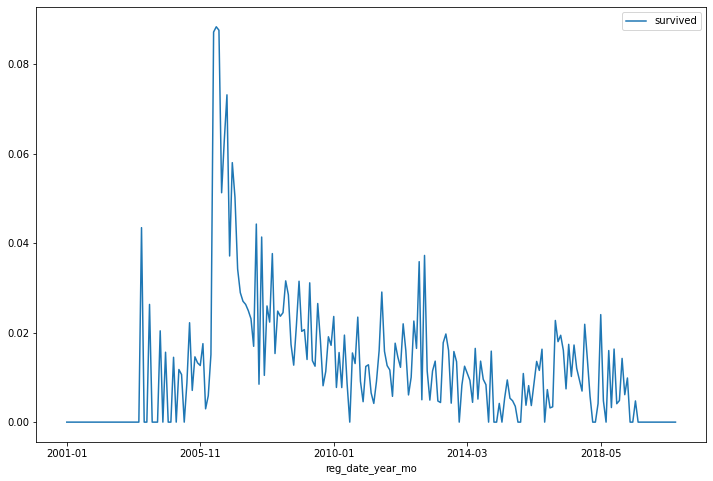

In [19]:
retention_group = retention_df.groupby(["reg_date_year_mo"])
monthly_averages = retention_group.aggregate({"survived":np.mean})
#monthly_averages = monthly_averages.query("reg_date >= '2006-01'")
fig = monthly_averages.plot(figsize=(12,8))


## Assignment 2

This does not check to see if the editor actually made an edit to an article, only that they registered. Expand to filter out every user who did not make an edit in their first six months. You will need to either keep the first query to the revision table for every user and add a second query for every user to filter out those who did not make an edit --- or (recommended) you can modify the first query to revision table in the database to do return a result for all 12 months, which will let you measure survival and do the filtering. Remember that you must join with the page table to filter by namespaces (articles are namespace 0). Here is an example query for getting a user's edits: https://quarry.wmcloud.org/query/59069
